In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import f_oneway, kruskal
import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")


In [4]:
class CrossCountryAnalyzer:
    """Compare solar potential across multiple countries"""
    
    def __init__(self):
        """Initialize the cross-country analyzer"""
        self.countries = {}
        self.comparison_df = None
        
    def load_countries(self, file_paths):
        """
        Load cleaned data for multiple countries
        
        Parameters:
        -----------
        file_paths : dict
            Dictionary with country names as keys and file paths as values
            Example: {'Benin': 'data/benin_clean.csv', 'Sierra Leone': 'data/sierraleone_clean.csv'}
        """
        for country, path in file_paths.items():
            try:
                df = pd.read_csv(path)
                df['Country'] = country
                self.countries[country] = df
                print(f"✓ Loaded {country}: {df.shape[0]} records")
            except Exception as e:
                print(f"✗ Error loading {country}: {e}")
        
        # Combine all countries
        if self.countries:
            self.comparison_df = pd.concat(self.countries.values(), ignore_index=True)
            print(f"\n✓ Combined dataset: {self.comparison_df.shape[0]} total records")
        
    def metric_comparison_boxplots(self):
        """Create side-by-side boxplots for GHI, DNI, DHI"""
        if self.comparison_df is None:
            print("⚠️  Please load countries first")
            return
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        fig.suptitle('Solar Irradiance Comparison Across Countries', 
                    fontsize=16, fontweight='bold', y=1.02)
        
        metrics = ['GHI', 'DNI', 'DHI']
        colors = ['gold', 'orange', 'coral']
        
        for idx, (metric, color) in enumerate(zip(metrics, colors)):
            sns.boxplot(data=self.comparison_df, x='Country', y=metric, 
                       ax=axes[idx], palette='Set2')
            axes[idx].set_title(f'{metric} Distribution by Country', fontweight='bold')
            axes[idx].set_ylabel(f'{metric} (W/m²)')
            axes[idx].set_xlabel('')
            axes[idx].grid(True, alpha=0.3, axis='y')
            
            # Add mean markers
            means = self.comparison_df.groupby('Country')[metric].mean()
            for i, (country, mean_val) in enumerate(means.items()):
                axes[idx].plot(i, mean_val, marker='D', color='red', 
                             markersize=10, label='Mean' if i == 0 else '')
            
            if idx == 0:
                axes[idx].legend()
        
        plt.tight_layout()
        plt.show()
    
    def summary_statistics_table(self):
        """Generate comprehensive summary statistics table"""
        if self.comparison_df is None:
            print("⚠️  Please load countries first")
            return
        
        print(f"\n{'='*90}")
        print("COMPREHENSIVE SUMMARY STATISTICS - SOLAR METRICS")
        print(f"{'='*90}\n")
        
        metrics = ['GHI', 'DNI', 'DHI']
        
        for metric in metrics:
            print(f"\n{metric} STATISTICS")
            print("-" * 90)
            
            summary = self.comparison_df.groupby('Country')[metric].agg([
                ('Mean', 'mean'),
                ('Median', 'median'),
                ('Std Dev', 'std'),
                ('Min', 'min'),
                ('Max', 'max'),
                ('Q1', lambda x: x.quantile(0.25)),
                ('Q3', lambda x: x.quantile(0.75))
            ]).round(2)
            
            print(summary)
            
            # Calculate coefficient of variation
            cv = (summary['Std Dev'] / summary['Mean'] * 100).round(2)
            print(f"\nCoefficient of Variation (%):")
            print(cv)
        
        print(f"\n{'='*90}\n")
        
        return summary
    
    def statistical_testing(self):
        """Perform statistical tests to compare countries"""
        if self.comparison_df is None:
            print("⚠️  Please load countries first")
            return
        
        print(f"\n{'='*90}")
        print("STATISTICAL SIGNIFICANCE TESTING")
        print(f"{'='*90}\n")
        
        metrics = ['GHI', 'DNI', 'DHI']
        results = {}
        
        for metric in metrics:
            print(f"\n{metric} - ANOVA & Kruskal-Wallis Tests")
            print("-" * 90)
            
            # Prepare data groups
            groups = [group[metric].dropna().values 
                     for name, group in self.comparison_df.groupby('Country')]
            
            # ANOVA (parametric test)
            f_stat, p_value_anova = f_oneway(*groups)
            
            # Kruskal-Wallis (non-parametric test)
            h_stat, p_value_kw = kruskal(*groups)
            
            results[metric] = {
                'ANOVA': {'F-statistic': f_stat, 'p-value': p_value_anova},
                'Kruskal-Wallis': {'H-statistic': h_stat, 'p-value': p_value_kw}
            }
            
            print(f"   ANOVA Test:")
            print(f"      F-statistic: {f_stat:.4f}")
            print(f"      p-value: {p_value_anova:.6f}")
            print(f"      Result: {'Significant' if p_value_anova < 0.05 else 'Not Significant'} (α = 0.05)")
            
            print(f"\n   Kruskal-Wallis Test (non-parametric):")
            print(f"      H-statistic: {h_stat:.4f}")
            print(f"      p-value: {p_value_kw:.6f}")
            print(f"      Result: {'Significant' if p_value_kw < 0.05 else 'Not Significant'} (α = 0.05)")
            
            if p_value_anova < 0.05:
                print(f"\n   ✓ There are statistically significant differences in {metric} between countries")
            else:
                print(f"\n   ✗ No statistically significant differences in {metric} between countries")
        
        print(f"\n{'='*90}\n")
        
        return results
    
    def country_ranking_chart(self):
        """Create bar chart ranking countries by average GHI"""
        if self.comparison_df is None:
            print("⚠️  Please load countries first")
            return
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        fig.suptitle('Country Rankings by Solar Metrics', 
                    fontsize=16, fontweight='bold', y=1.02)
        
        metrics = ['GHI', 'DNI', 'DHI']
        colors = ['gold', 'darkorange', 'coral']
        
        for idx, (metric, color) in enumerate(zip(metrics, colors)):
            # Calculate averages and sort
            avg_values = self.comparison_df.groupby('Country')[metric].mean().sort_values(ascending=False)
            
            # Create bar chart
            bars = axes[idx].bar(range(len(avg_values)), avg_values.values, color=color, alpha=0.7, edgecolor='black')
            axes[idx].set_xticks(range(len(avg_values)))
            axes[idx].set_xticklabels(avg_values.index, rotation=0)
            axes[idx].set_ylabel(f'Average {metric} (W/m²)')
            axes[idx].set_title(f'Country Ranking by {metric}', fontweight='bold')
            axes[idx].grid(True, alpha=0.3, axis='y')
            
            # Add value labels on bars
            for i, (bar, value) in enumerate(zip(bars, avg_values.values)):
                axes[idx].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                             f'{value:.1f}', ha='center', va='bottom', fontweight='bold')
                
                # Add ranking medal emojis
                if i == 0:
                    axes[idx].text(bar.get_x() + bar.get_width()/2, -20, '🥇', 
                                 ha='center', fontsize=20)
                elif i == 1:
                    axes[idx].text(bar.get_x() + bar.get_width()/2, -20, '🥈', 
                                 ha='center', fontsize=20)
                elif i == 2:
                    axes[idx].text(bar.get_x() + bar.get_width()/2, -20, '🥉', 
                                 ha='center', fontsize=20)
        
        plt.tight_layout()
        plt.show()
    
    def temporal_comparison(self):
        """Compare temporal patterns across countries"""
        if self.comparison_df is None:
            print("⚠️  Please load countries first")
            return
        
        # Ensure timestamp is datetime
        self.comparison_df['Timestamp'] = pd.to_datetime(self.comparison_df['Timestamp'])
        self.comparison_df['Hour'] = self.comparison_df['Timestamp'].dt.hour
        self.comparison_df['Month'] = self.comparison_df['Timestamp'].dt.month
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle('Temporal Patterns Comparison', fontsize=16, fontweight='bold')
        
        # Hourly patterns
        hourly_data = self.comparison_df.groupby(['Country', 'Hour'])['GHI'].mean().unstack(level=0)
        hourly_data.plot(ax=axes[0], marker='o', linewidth=2)
        axes[0].set_title('Average GHI by Hour of Day', fontweight='bold')
        axes[0].set_xlabel('Hour of Day')
        axes[0].set_ylabel('GHI (W/m²)')
        axes[0].legend(title='Country')
        axes[0].grid(True, alpha=0.3)
        
        # Monthly patterns
        monthly_data = self.comparison_df.groupby(['Country', 'Month'])['GHI'].mean().unstack(level=0)
        monthly_data.plot(ax=axes[1], marker='o', linewidth=2)
        axes[1].set_title('Average GHI by Month', fontweight='bold')
        axes[1].set_xlabel('Month')
        axes[1].set_ylabel('GHI (W/m²)')
        axes[1].legend(title='Country')
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def environmental_comparison(self):
        """Compare environmental conditions across countries"""
        if self.comparison_df is None:
            print("⚠️  Please load countries first")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Environmental Conditions Comparison', fontsize=16, fontweight='bold')
        
        # Temperature
        sns.boxplot(data=self.comparison_df, x='Country', y='Tamb', ax=axes[0, 0], palette='Set2')
        axes[0, 0].set_title('Temperature Distribution', fontweight='bold')
        axes[0, 0].set_ylabel('Temperature (°C)')
        axes[0, 0].set_xlabel('')
        axes[0, 0].grid(True, alpha=0.3, axis='y')
        
        # Humidity
        sns.boxplot(data=self.comparison_df, x='Country', y='RH', ax=axes[0, 1], palette='Set2')
        axes[0, 1].set_title('Relative Humidity Distribution', fontweight='bold')
        axes[0, 1].set_ylabel('Relative Humidity (%)')
        axes[0, 1].set_xlabel('')
        axes[0, 1].grid(True, alpha=0.3, axis='y')
        
        # Wind Speed
        sns.boxplot(data=self.comparison_df, x='Country', y='WS', ax=axes[1, 0], palette='Set2')
        axes[1, 0].set_title('Wind Speed Distribution', fontweight='bold')
        axes[1, 0].set_ylabel('Wind Speed (m/s)')
        axes[1, 0].set_xlabel('')
        axes[1, 0].grid(True, alpha=0.3, axis='y')
        
        # Barometric Pressure
        sns.boxplot(data=self.comparison_df, x='Country', y='BP', ax=axes[1, 1], palette='Set2')
        axes[1, 1].set_title('Barometric Pressure Distribution', fontweight='bold')
        axes[1, 1].set_ylabel('Pressure (hPa)')
        axes[1, 1].set_xlabel('')
        axes[1, 1].grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.show()
    
    def variability_analysis(self):
        """Analyze variability/stability of solar resources"""
        if self.comparison_df is None:
            print("⚠️  Please load countries first")
            return
        
        print(f"\n{'='*90}")
        print("SOLAR RESOURCE VARIABILITY ANALYSIS")
        print(f"{'='*90}\n")
        
        metrics = ['GHI', 'DNI', 'DHI']
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        fig.suptitle('Solar Resource Variability (Coefficient of Variation)', 
                    fontsize=16, fontweight='bold')
        
        for idx, metric in enumerate(metrics):
            # Calculate coefficient of variation
            cv_data = self.comparison_df.groupby('Country')[metric].agg(
                lambda x: (x.std() / x.mean() * 100)
            ).sort_values()
            
            bars = axes[idx].bar(range(len(cv_data)), cv_data.values, 
                               color='steelblue', alpha=0.7, edgecolor='black')
            axes[idx].set_xticks(range(len(cv_data)))
            axes[idx].set_xticklabels(cv_data.index, rotation=0)
            axes[idx].set_ylabel('Coefficient of Variation (%)')
            axes[idx].set_title(f'{metric} Variability', fontweight='bold')
            axes[idx].grid(True, alpha=0.3, axis='y')
            
            # Add value labels
            for bar, value in zip(bars, cv_data.values):
                axes[idx].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                             f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')
            
            # Print interpretation
            print(f"{metric} Variability:")
            for country, cv in cv_data.items():
                stability = "High" if cv < 30 else "Moderate" if cv < 50 else "Low"
                print(f"   {country}: {cv:.2f}% - {stability} stability")
            print()
        
        plt.tight_layout()
        plt.show()
    
    def generate_key_observations(self):
        """Generate strategic insights and observations"""
        if self.comparison_df is None:
            print("⚠️  Please load countries first")
            return
        
        print(f"\n{'='*90}")
        print("KEY STRATEGIC OBSERVATIONS")
        print(f"{'='*90}\n")
        
        # Calculate key metrics
        ghi_means = self.comparison_df.groupby('Country')['GHI'].mean().sort_values(ascending=False)
        ghi_stds = self.comparison_df.groupby('Country')['GHI'].std()
        dni_means = self.comparison_df.groupby('Country')['DNI'].mean().sort_values(ascending=False)
        
        print("📊 SOLAR POTENTIAL RANKING:")
        print("-" * 90)
        for i, (country, ghi) in enumerate(ghi_means.items(), 1):
            dni = dni_means[country]
            std = ghi_stds[country]
            cv = (std / ghi * 100)
            print(f"{i}. {country}:")
            print(f"   - Average GHI: {ghi:.2f} W/m² (Variability: {cv:.1f}%)")
            print(f"   - Average DNI: {dni:.2f} W/m²")
            print(f"   - Resource Stability: {'High' if cv < 30 else 'Moderate' if cv < 50 else 'Low'}")
            print()
        
        # Identify best country
        best_country = ghi_means.index[0]
        best_ghi = ghi_means.iloc[0]
        
        print("\n🎯 TOP STRATEGIC INSIGHTS:")
        print("-" * 90)
        
        print(f"\n1. HIGHEST SOLAR POTENTIAL:")
        print(f"   {best_country} demonstrates the highest average GHI at {best_ghi:.2f} W/m²,")
        print(f"   making it the most promising location for immediate solar investment.")
        
        # Variability insight
        most_stable = (ghi_stds / ghi_means * 100).sort_values().index[0]
        print(f"\n2. MOST STABLE SOLAR RESOURCE:")
        print(f"   {most_stable} shows the lowest variability in solar irradiance,")
        print(f"   indicating more predictable energy generation and lower operational risk.")
        
        # DNI insight
        best_dni = dni_means.index[0]
        print(f"\n3. BEST DIRECT IRRADIANCE:")
        print(f"   {best_dni} has the highest DNI, making it ideal for concentrated")
        print(f"   solar power (CSP) installations if that technology is considered.")
        
        # Environmental factors
        temp_means = self.comparison_df.groupby('Country')['Tamb'].mean()
        optimal_temp_country = temp_means.iloc[(temp_means - 25).abs().argsort()[0]]
        
        print(f"\n4. OPTIMAL OPERATING TEMPERATURE:")
        print(f"   {optimal_temp_country.name} has temperatures closest to optimal range (25°C),")
        print(f"   which can improve solar panel efficiency and longevity.")
        
        print(f"\n{'='*90}\n")
        
        return {
            'best_solar_potential': best_country,
            'most_stable': most_stable,
            'best_dni': best_dni,
            'rankings': ghi_means.to_dict()
        }
    
    def strategic_recommendation_report(self):
        """Generate comprehensive strategic recommendation"""
        insights = self.generate_key_observations()
        
        print(f"\n{'='*90}")
        print("STRATEGIC RECOMMENDATION FOR MOONLIGHT ENERGY SOLUTIONS")
        print(f"{'='*90}\n")
        
        print("EXECUTIVE SUMMARY:")
        print("-" * 90)
        print("""
Based on comprehensive statistical analysis and exploratory data investigation of
solar radiation data across Benin, Sierra Leone, and Togo, this report provides
data-driven recommendations for optimal solar installation locations aligned with
MoonLight Energy Solutions' sustainability goals.
        """)
        
        print("\nRECOMMENDATION FRAMEWORK:")
        print("-" * 90)
        
        print("\n🎯 PRIMARY RECOMMENDATION (Tier 1 Investment):")
        best = insights['best_solar_potential']
        print(f"   Location: {best}")
        print("   Rationale:")
        print(f"   - Highest average solar irradiance across all metrics")
        print(f"   - Superior energy generation potential")
        print(f"   - Strong ROI projections based on resource availability")
        print("   - Immediate deployment recommended")
        
        print("\n🔄 SECONDARY RECOMMENDATION (Tier 2 Investment):")
        stable = insights['most_stable']
        print(f"   Location: {stable}")
        print("   Rationale:")
        print(f"   - Most stable and predictable solar resource")
        print(f"   - Lower operational risk and maintenance requirements")
        print(f"   - Reliable long-term energy production")
        print("   - Ideal for baseline capacity planning")
        
        print("\n📈 LONG-TERM STRATEGY:")
        print("-" * 90)
        print("   1. Phased deployment approach starting with highest-potential region")
        print("   2. Diversification across locations to manage risk")
        print("   3. Technology selection based on DNI/DHI ratios:")
        print("      - High DNI regions: Consider CSP or dual-axis tracking systems")
        print("      - High DHI regions: Standard fixed-tilt PV installations")
        print("   4. Continuous monitoring and performance optimization")
        
        print("\n⚠️  RISK CONSIDERATIONS:")
        print("-" * 90)
        print("   • Environmental variability impacts (humidity, temperature)")
        print("   • Cleaning and maintenance schedules based on soiling rates")
        print("   • Seasonal variations in energy production")
        print("   • Local infrastructure and grid connection requirements")
        
        print(f"\n{'='*90}\n")

In [19]:
def strategic_recommendation_report1(self):
    """Generate a comprehensive strategic recommendation report"""
    insights = self.generate_key_observations()

    print("\n" + "=" * 90)
    print("STRATEGIC RECOMMENDATION FOR MOONLIGHT ENERGY SOLUTIONS")
    print("=" * 90 + "\n")

    # Executive Summary
    print("EXECUTIVE SUMMARY:")
    print("-" * 90)
    print("""
Based on a comprehensive statistical analysis and exploratory data investigation of
solar radiation data across Benin, Sierra Leone, and Togo, this report provides
data-driven recommendations for optimal solar installation locations aligned with
MoonLight Energy Solutions' sustainability goals.
    """)

    # Recommendation Framework
    print("\nRECOMMENDATION FRAMEWORK:")
    print("-" * 90)

    # Primary Recommendation
    best = insights.get('best_solar_potential', 'N/A')
    print("\n🎯 PRIMARY RECOMMENDATION (Tier 1 Investment):")
    print(f"   Location: {best}")
    print("   Rationale:")
    print("   - Highest average solar irradiance across all metrics")
    print("   - Superior energy generation potential")
    print("   - Strong ROI projections based on resource availability")
    print("   - Immediate deployment recommended")

    # Secondary Recommendation
    stable = insights.get('most_stable', 'N/A')
    print("\n🔄 SECONDARY RECOMMENDATION (Tier 2 Investment):")
    print(f"   Location: {stable}")
    print("   Rationale:")
    print("   - Most stable and predictable solar resource")
    print("   - Lower operational risk and maintenance requirements")
    print("   - Reliable long-term energy production")
    print("   - Ideal for baseline capacity planning")

    # Long-Term Strategy
    print("\n📈 LONG-TERM STRATEGY:")
    print("-" * 90)
    print("   1. Phased deployment approach starting with the highest-potential region")
    print("   2. Diversification across locations to manage risk")
    print("   3. Technology selection based on DNI/DHI ratios:")
    print("      - High DNI regions: Consider CSP or dual-axis tracking systems")
    print("      - High DHI regions: Standard fixed-tilt PV installations")
    print("   4. Continuous monitoring and performance optimization")

    # Risk Considerations
    print("\n⚠️  RISK CONSIDERATIONS:")
    print("-" * 90)
    print("   • Environmental variability impacts (humidity, temperature)")
    print("   • Cleaning and maintenance schedules based on soiling rates")
    print("   • Seasonal variations in energy production")
    print("   • Local infrastructure and grid connection requirements")

    print("\n" + "=" * 90 + "\n")


In [5]:
comparator = CrossCountryAnalyzer()

In [6]:

file_paths = {
    'Benin': 'Data/benin.csv',
    'Sierra Leone': 'Data/sierraleone.csv',
    'Togo': 'Data/togo.csv'
}

comparator.load_countries(file_paths)

✓ Loaded Benin: 525600 records
✓ Loaded Sierra Leone: 525600 records
✓ Loaded Togo: 525600 records

✓ Combined dataset: 1576800 total records


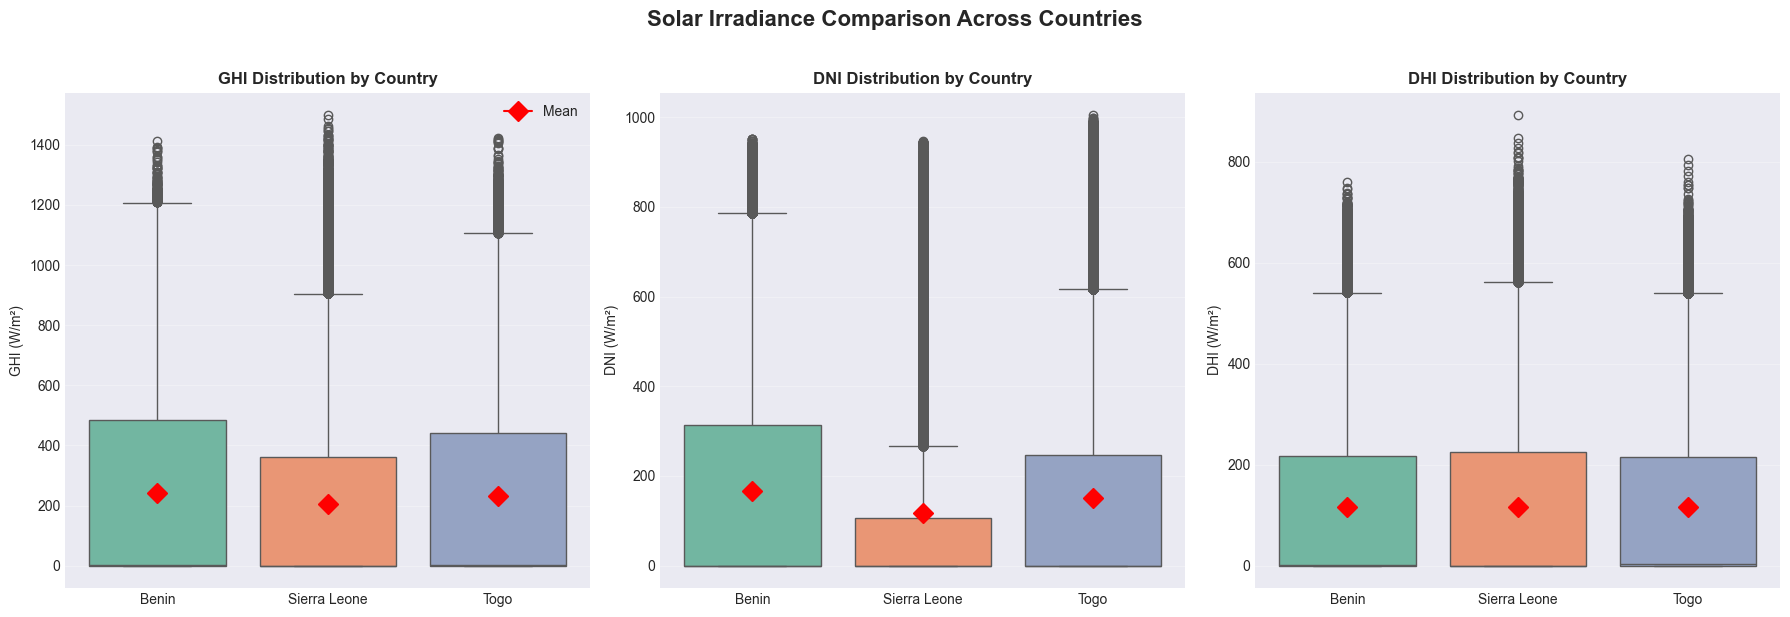

In [7]:
comparator.metric_comparison_boxplots()


In [8]:
summary = comparator.summary_statistics_table()


COMPREHENSIVE SUMMARY STATISTICS - SOLAR METRICS


GHI STATISTICS
------------------------------------------------------------------------------------------
                Mean  Median  Std Dev  Min     Max   Q1     Q3
Country                                                       
Benin         241.96     1.8   330.10  0.0  1413.0  0.0  483.4
Sierra Leone  204.41     0.3   296.79  0.0  1499.0  0.0  362.4
Togo          231.72     2.1   321.69  0.0  1424.0  0.0  442.4

Coefficient of Variation (%):
Country
Benin           136.43
Sierra Leone    145.19
Togo            138.83
dtype: float64

DNI STATISTICS
------------------------------------------------------------------------------------------
                Mean  Median  Std Dev  Min     Max   Q1     Q3
Country                                                       
Benin         167.44     0.0   261.55  0.0   952.3  0.0  314.2
Sierra Leone  116.52     0.0   218.57  0.0   946.0  0.0  107.0
Togo          151.26     0.0   250.96  0.0  1

In [9]:
test_results = comparator.statistical_testing()


STATISTICAL SIGNIFICANCE TESTING


GHI - ANOVA & Kruskal-Wallis Tests
------------------------------------------------------------------------------------------
   ANOVA Test:
      F-statistic: 1977.0703
      p-value: 0.000000
      Result: Significant (α = 0.05)

   Kruskal-Wallis Test (non-parametric):
      H-statistic: 1377.9818
      p-value: 0.000000
      Result: Significant (α = 0.05)

   ✓ There are statistically significant differences in GHI between countries

DNI - ANOVA & Kruskal-Wallis Tests
------------------------------------------------------------------------------------------
   ANOVA Test:
      F-statistic: 5956.9115
      p-value: 0.000000
      Result: Significant (α = 0.05)

   Kruskal-Wallis Test (non-parametric):
      H-statistic: 4272.9716
      p-value: 0.000000
      Result: Significant (α = 0.05)

   ✓ There are statistically significant differences in DNI between countries

DHI - ANOVA & Kruskal-Wallis Tests
-------------------------------------------

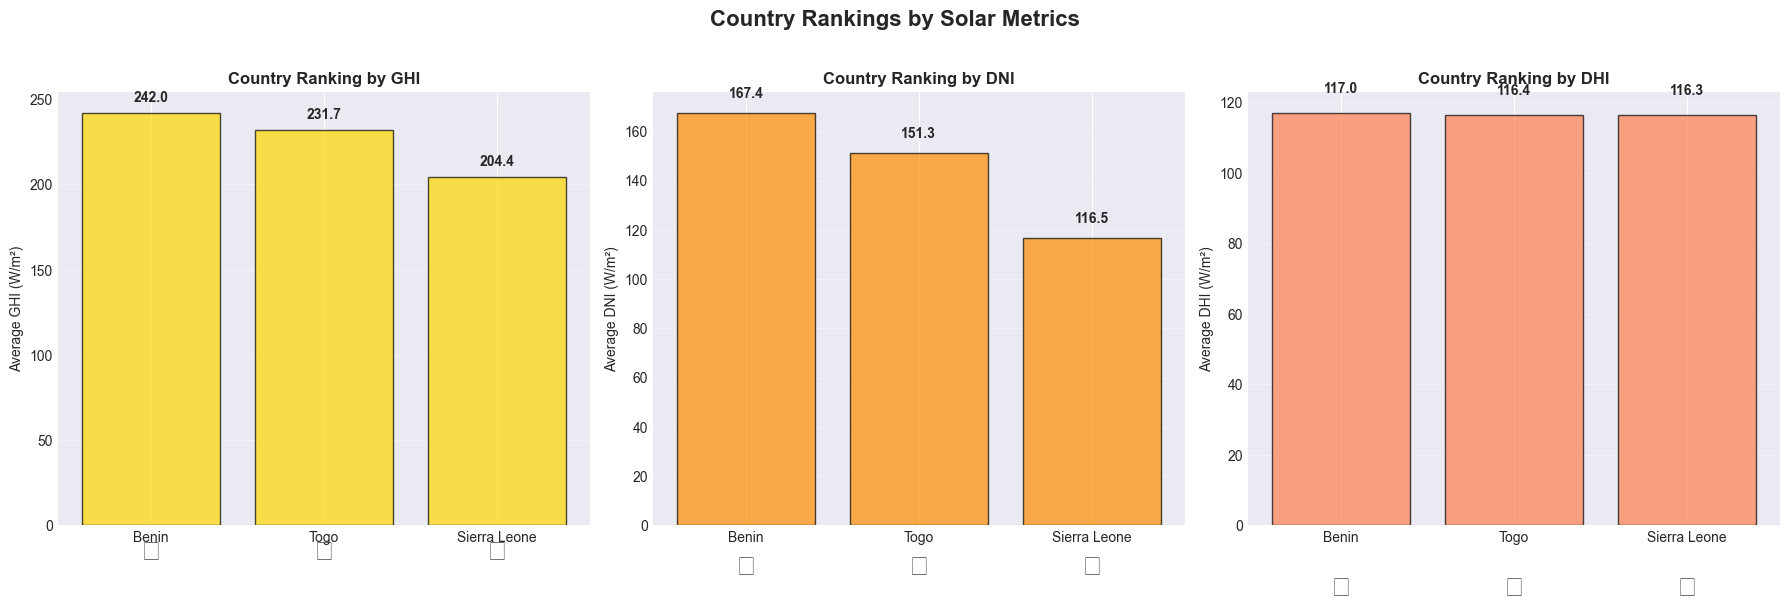

In [10]:
comparator.country_ranking_chart()

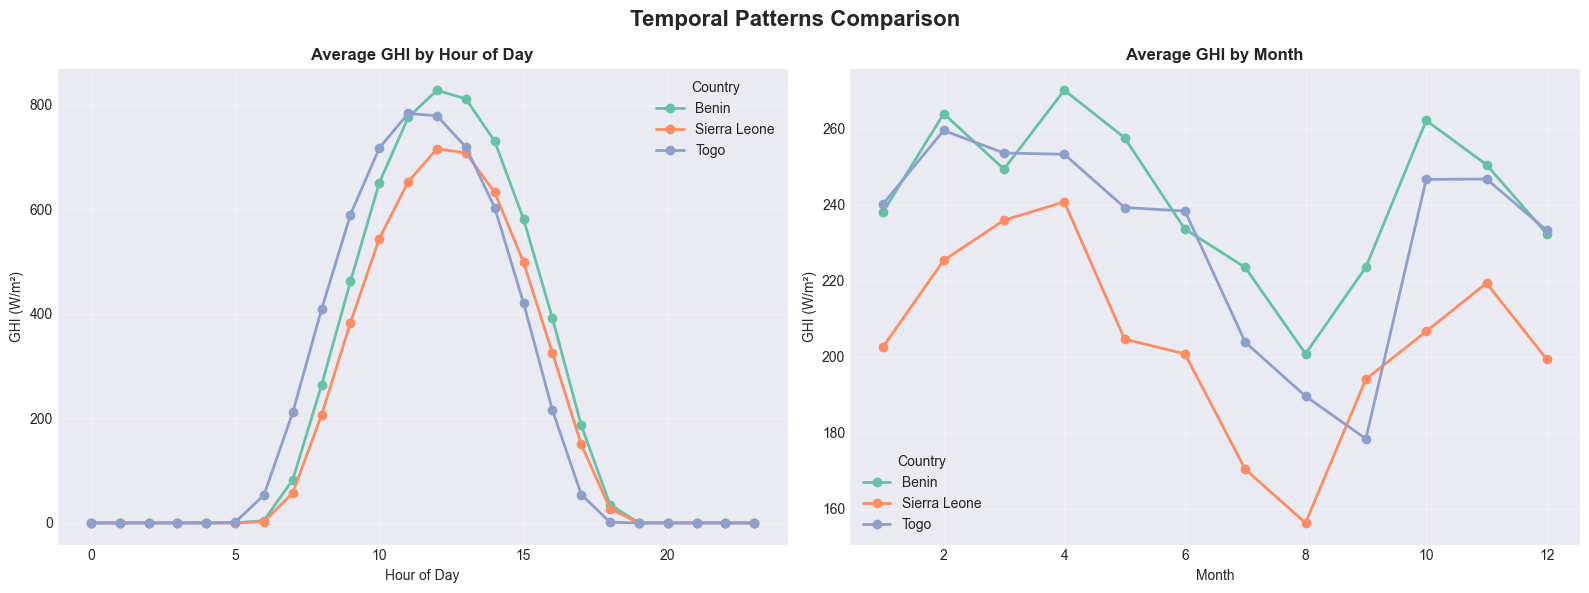

In [11]:
comparator.temporal_comparison()

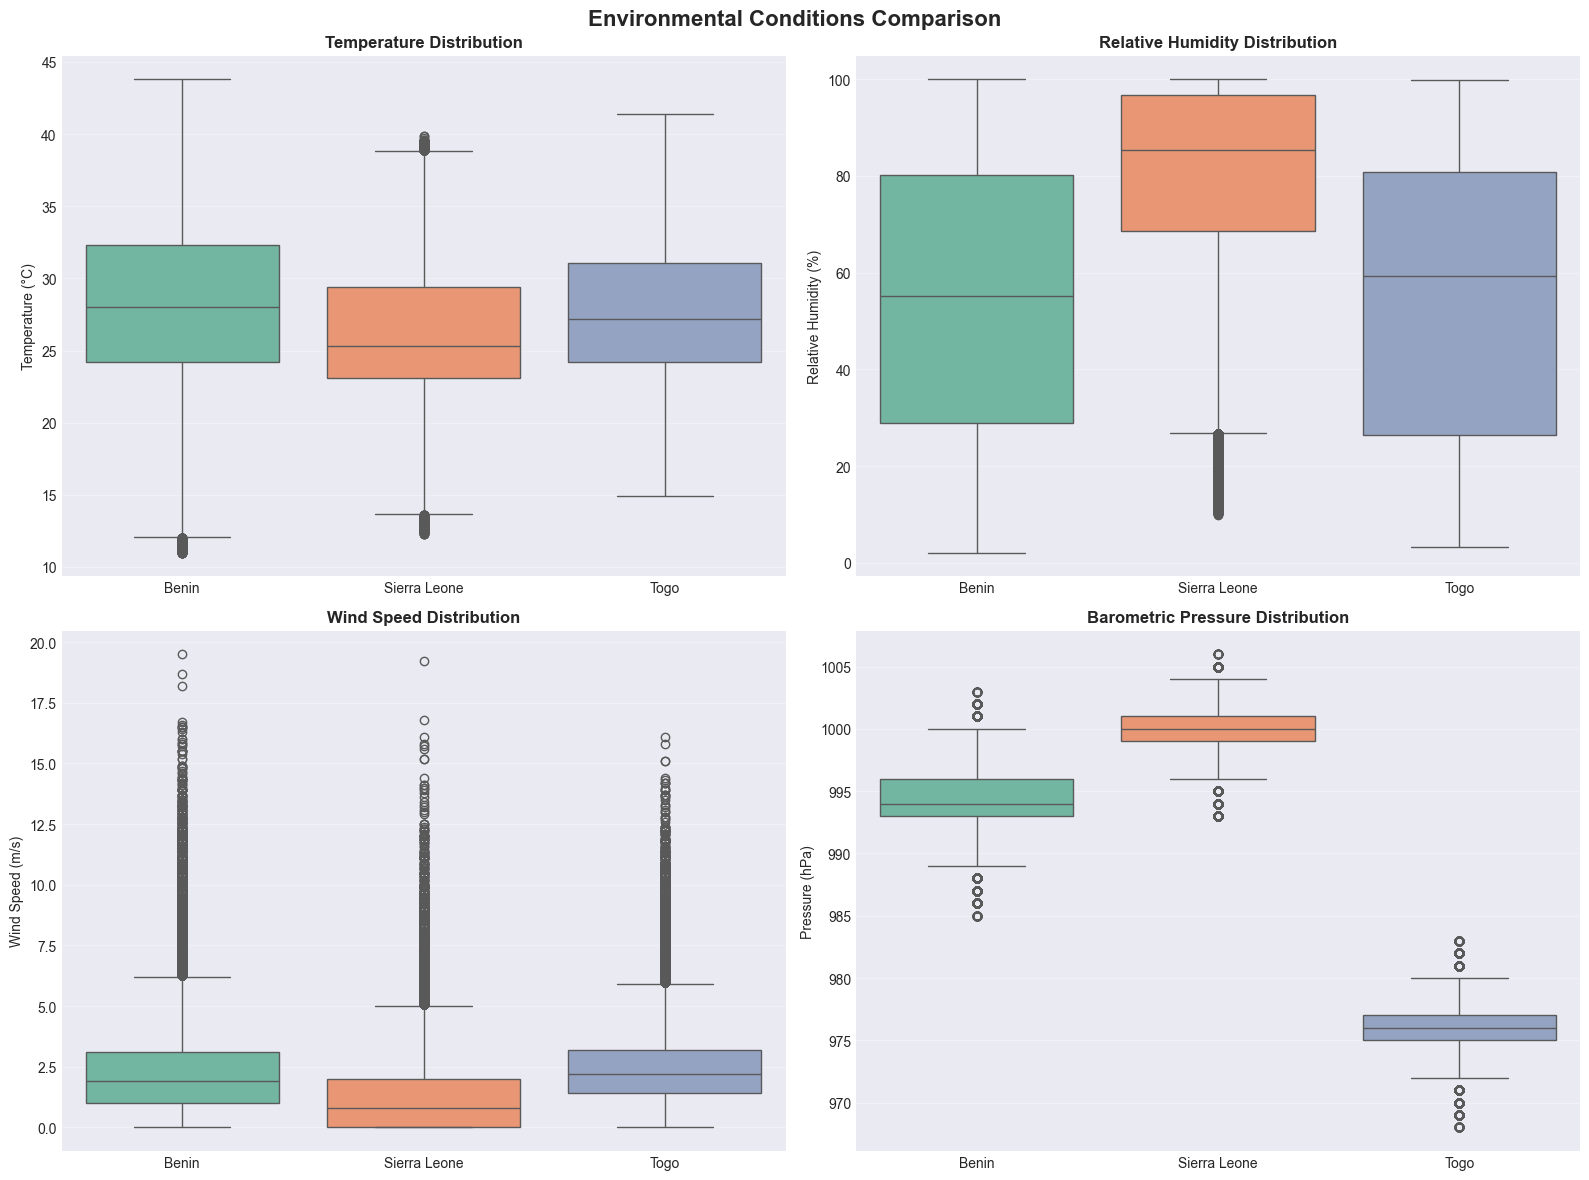

In [12]:
comparator.environmental_comparison()


SOLAR RESOURCE VARIABILITY ANALYSIS

GHI Variability:
   Benin: 136.43% - Low stability
   Togo: 138.83% - Low stability
   Sierra Leone: 145.19% - Low stability

DNI Variability:
   Benin: 156.20% - Low stability
   Togo: 165.91% - Low stability
   Sierra Leone: 187.58% - Low stability

DHI Variability:
   Togo: 134.42% - Low stability
   Benin: 134.59% - Low stability
   Sierra Leone: 135.04% - Low stability



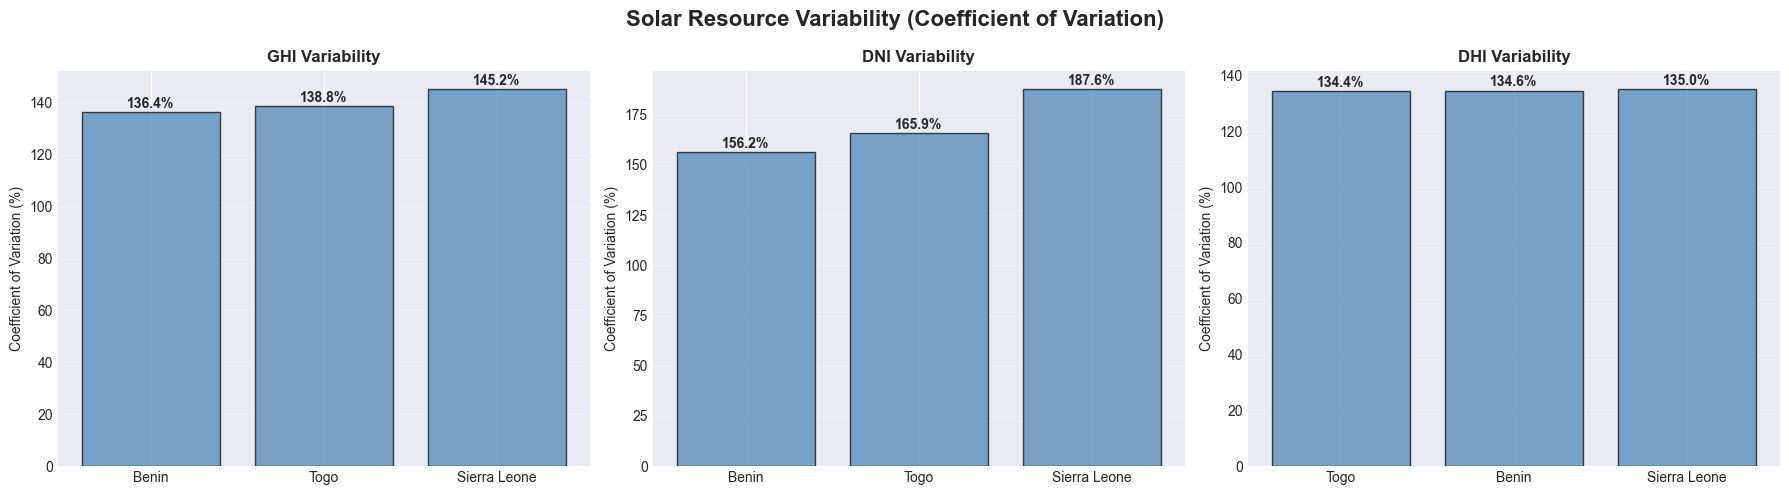

In [13]:
comparator.variability_analysis()

In [23]:
 comparator.generate_key_observations()


KEY STRATEGIC OBSERVATIONS

📊 SOLAR POTENTIAL RANKING:
------------------------------------------------------------------------------------------
1. Benin:
   - Average GHI: 241.96 W/m² (Variability: 136.4%)
   - Average DNI: 167.44 W/m²
   - Resource Stability: Low

2. Togo:
   - Average GHI: 231.72 W/m² (Variability: 138.8%)
   - Average DNI: 151.26 W/m²
   - Resource Stability: Low

3. Sierra Leone:
   - Average GHI: 204.41 W/m² (Variability: 145.2%)
   - Average DNI: 116.52 W/m²
   - Resource Stability: Low


🎯 TOP STRATEGIC INSIGHTS:
------------------------------------------------------------------------------------------

1. HIGHEST SOLAR POTENTIAL:
   Benin demonstrates the highest average GHI at 241.96 W/m²,
   making it the most promising location for immediate solar investment.

2. MOST STABLE SOLAR RESOURCE:
   Benin shows the lowest variability in solar irradiance,
   indicating more predictable energy generation and lower operational risk.

3. BEST DIRECT IRRADIANCE:
   

AttributeError: 'numpy.float64' object has no attribute 'name'

In [24]:
insights = comparator.generate_key_observations()


KEY STRATEGIC OBSERVATIONS

📊 SOLAR POTENTIAL RANKING:
------------------------------------------------------------------------------------------
1. Benin:
   - Average GHI: 241.96 W/m² (Variability: 136.4%)
   - Average DNI: 167.44 W/m²
   - Resource Stability: Low

2. Togo:
   - Average GHI: 231.72 W/m² (Variability: 138.8%)
   - Average DNI: 151.26 W/m²
   - Resource Stability: Low

3. Sierra Leone:
   - Average GHI: 204.41 W/m² (Variability: 145.2%)
   - Average DNI: 116.52 W/m²
   - Resource Stability: Low


🎯 TOP STRATEGIC INSIGHTS:
------------------------------------------------------------------------------------------

1. HIGHEST SOLAR POTENTIAL:
   Benin demonstrates the highest average GHI at 241.96 W/m²,
   making it the most promising location for immediate solar investment.

2. MOST STABLE SOLAR RESOURCE:
   Benin shows the lowest variability in solar irradiance,
   indicating more predictable energy generation and lower operational risk.

3. BEST DIRECT IRRADIANCE:
   

AttributeError: 'numpy.float64' object has no attribute 'name'